In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl

import time
import sys
%matplotlib inline

In [14]:
from parity_machines.tree_machine import TreeParityMachine

In [15]:
def test_sync(k, n, l, update_rule='hebbian', echo=False, max_time=float('inf')):

	A = TreeParityMachine(n, k, l, update_rule=update_rule)
	B = TreeParityMachine(n, k, l, update_rule=update_rule)
	E = TreeParityMachine(n, k, l, update_rule=update_rule)

	def sync_score(m1, m2):
		return 1.0 - np.average(1.0 * np.abs(m1.W - m2.W)/(2 * l))

	sync = False 
	updates = 0
	eve_updates = 0 
	scores = [] 
	eve_scores = []

	ctr=0
	Y = []
	t1 = time.time()
	while(not sync):
		X = A.generate_input()

		y_A = A.forward(X) 
		y_B = B.forward(X) 
		y_E = E.forward(X) 
		A.update(y_B)
		B.update(y_A)
		updates += 1

		if y_A == y_B == y_E:
			E.update(y_A)
			eve_updates += 1

		score = sync_score(A, B) 
		scores.append(score)
		score_EA = sync_score(A, E)
		score_EB = sync_score(B, E)
		eve_scores.append((score_EA, score_EB))

		if y_A == y_B:
			ctr+=1
		else:
			ctr = 0

		# sync = score == 1
		sync = ctr > n + k + l

		score_format = lambda s: str(int(s * 100))
		if echo:
			sys.stdout.write(f"\rSynchronization(AB, EA, EB) = ({score_format(score)}, {score_format(score_EA)}, {score_format(score_EB)})%   /" \
			+ f"  Updates(AB, EAB)  = ({str(updates)}, {str(eve_updates)})") 
	
	if time.time() - t1 > max_time:
		raise TimeoutError()



	time_taken = time.time() - t1

	if echo:
		if sync:
			print('\nAlice and Bob are synchronized.')
		if eve_scores[-1][0] == 1:
			print('Eve is also synchornized !!!')
	return {'synced': (A.W == B.W).all(),
	  		'time': time_taken,
	    	'updates': updates,
		  	'eve_updates': eve_updates,
		    'alice': A, 'bob': B, 'eve': E,
			'scores': np.array(scores),
			'eve_scores': np.array(eve_scores)}


def plot_res(res):
    scores = res['scores']
    eve_scores= res['eve_scores']

    mpl.plot(scores)
    mpl.plot(eve_scores[:, 0])
    mpl.plot(eve_scores[:, 1])
    plt.xlabel('updates')
    plt.ylabel('sync score')
    plt.legend(['Alice/Bob score', 'Eve/Alice score', 'Eve/Bob score'])
    print('Synced: ' + str(res['synced']))


Synchronization(AB, EA, EB) = (100, 67, 67)%   /  Updates(AB, EAB)  = (3882, 1778)
Alice and Bob are synchronized.
Synced: True


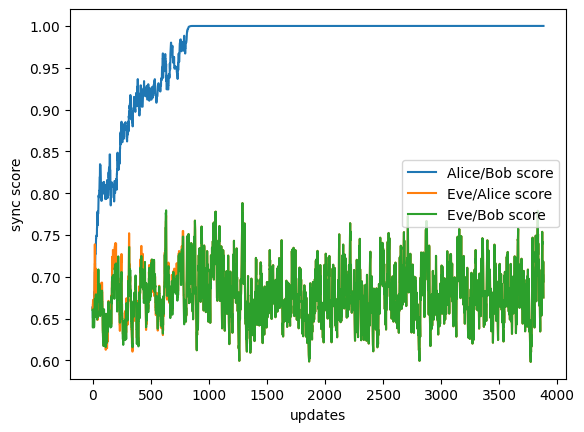

In [20]:
update_rules = ['hebbian', 'anti_hebbian', 'random_walk']
res = test_sync(k=20, n=3000, l=30, update_rule=update_rules[0], echo=True, max_time=55)
plot_res(res)

In [17]:
# ctr = 0
# correct = 0
# nc = []
# D = (10, 30)
# iters = 10
# mi = iters * (D[1] - D[0]) ** 3
# for k in range(10, 20):
#     for n in range(k + 10, k + 30):
#         for l in range(*D):
#             for _ in range(iters):
#                 ctr += 1
#                 res = test_sync(k=k, n=n, l=l, update_rule='hebbian', echo=False, max_time=55)
#                 synced = res['synced']
#                 correct += synced
#                 if not synced:
#                     print(f'oops!!!: {len(nc)}\n')
#                     nc.append((k,n,l))
#                 sys.stdout.write(f"\r {ctr} / {mi}")



In [18]:
alice = res['alice']
bob = res['bob']
eve = res['eve']